In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0   1210      0 --:--:-- --:--:-- --:--:--  1208
100  9.9M  100  9.9M    0     0  9368k      0  0:00:01  0:00:01 --:--:-- 9368k
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/_annotations.coco.json  
 extracting: test/frame1244_png.rf.a0de8a0c0d0e727cb4aef5c65b0c14d8.jpg  
 extracting: test/frame1379_png.rf.ca14261b88b4b6574708f0b5dfd66ded.jpg  
 extracting: test/frame2306_png.rf.f3d764d9ee17a3dcbe1dfd5ee2b51dd6.jpg  
 extracting: test/frame_1589_jpg.rf.467f882530e5dde1a3f723950d0c5a2e.jpg  
 extracting: test/img1_jpg.rf.180e4092988b3f9838523c6587e4c338.jpg  
   creating: train/
 extracting: train/_annotations.coco.json  
 extracting: train/frame1255_png.rf.02eb0173dc1c6eca4924c4005f6d4318.jpg  
 extracting: train/frame1255_png.rf.1c95cdc29c83ca98cea5

In [2]:
import json
from PIL import Image
import torch
from pycocotools import mask as coco_mask
from pycocotools.coco import COCO
import os
import numpy as np
class myDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, ann_path, transforms=None):
        self.img_dir = img_dir
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir( img_dir )))
        with open(ann_path,'r') as f:
            self.annotations = json.load(f)
         
    def __len__(self):
        return len(self.annotations["images"])

    def __getitem__(self, index):
        img_dir = self.img_dir
        annotations = self.annotations
        transforms = self.transforms

        file_name = annotations["images"][index]['file_name']
        img_path = os.path.join(img_dir, file_name)

        img = Image.open(img_path).convert("RGB")
        height = annotations["images"][index]['height']
        width = annotations["images"][index]['width']
        annotations =[(ann) for ann in self.annotations["annotations"] if ann['image_id'] == index]
        target = {}
        area = []
        labels = []
        masks = []
        boxes = []
        for annotation in annotations:
 
            area.append(annotation["area"])
            labels.append(annotation["category_id"])
            xmin = annotation['bbox'][0]
            xmax = annotation['bbox'][0]+annotation['bbox'][2]
            ymin = annotation['bbox'][1]
            ymax = annotation['bbox'][1]+annotation['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        target["boxes"] = boxes
        target["labels"] = torch.as_tensor(labels)
        target["image_id"] = torch.tensor([index])
        target["area"] = torch.tensor(area)
        target["iscrowd"] = torch.zeros(len(annotations), dtype=torch.int64)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

In [3]:
dataset = myDataset('/content/train',"/content/train/_annotations.coco.json")#,get_transform(train=True))
dataset[0]

(<PIL.Image.Image image mode=RGB size=512x512 at 0x7F4168FAAC10>,
 {'area': tensor([3376, 3200, 3914, 3376, 3424, 3024, 2100, 1404, 1290,  900, 3568]),
  'boxes': tensor([[236., 253., 447., 269.],
          [180., 261., 380., 277.],
          [137., 262., 343., 281.],
          [196., 236., 407., 252.],
          [171., 223., 385., 239.],
          [107., 212., 323., 226.],
          [ 59., 205., 269., 215.],
          [ 53., 193., 209., 202.],
          [ 71., 183., 200., 193.],
          [ 85., 173., 175., 183.],
          [ 38., 277., 261., 293.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])})

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

      
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
 
    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [5]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 21974, done.
remote: Counting objects: 100% (2756/2756), done.
remote: Compressing objects: 100% (623/623), done.
remote: Total 21974 (delta 2153), reused 2611 (delta 2065), pack-reused 19218
Receiving objects: 100% (21974/21974), 22.11 MiB | 15.68 MiB/s, done.
Resolving deltas: 100% (16211/16211), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [6]:
import transforms as T
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

In [7]:
import utils
dataset = myDataset('/content/train',"/content/train/_annotations.coco.json", get_transform(train=True))
dataset_test= myDataset('/content/test',"/content/test/_annotations.coco.json", get_transform(train=False))

# split the dataset in train and test set
# torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-5])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-5:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 4

# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [9]:
from engine import train_one_epoch, evaluate
# let's train it for 10 epochs
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [ 0/68]  eta: 0:01:19  lr: 0.000080  loss: 8.0601 (8.0601)  loss_classifier: 1.5176 (1.5176)  loss_box_reg: 0.0755 (0.0755)  loss_objectness: 5.6790 (5.6790)  loss_rpn_box_reg: 0.7880 (0.7880)  time: 1.1625  data: 0.2762  max mem: 1623
Epoch: [0]  [10/68]  eta: 0:00:25  lr: 0.000825  loss: 2.7889 (3.9497)  loss_classifier: 1.1460 (1.0565)  loss_box_reg: 0.2204 (0.2676)  loss_objectness: 0.6551 (2.0655)  loss_rpn_box_reg: 0.5907 (0.5602)  time: 0.4439  data: 0.0294  max mem: 1888
Epoch: [0]  [20/68]  eta: 0:00:19  lr: 0.001571  loss: 1.8406 (2.8670)  loss_classifier: 0.5461 (0.7906)  loss_box_reg: 0.4269 (0.3759)  loss_objectness: 0.3642 (1.1838)  loss_rpn_box_reg: 0.4485 (0.5166)  time: 0.3731  data: 0.0061  max mem: 1888
Epoch: [0]  [30/68]  eta: 0:00:15  lr: 0.002316  loss: 1.5777 (2.4012)  loss_classifier: 0.3772 (0.6516)  loss_box_reg: 0.4621 (0.4001)  loss_objectness: 0.1347 (0.8436)  loss_rpn_box_reg: 0.4342 (0.5058)  time: 0.3740  data: 0.0072  max mem: 1888
Epoch: [

In [14]:
torch.save(model, "/content/gdrive/MyDrive/Devoworm/Train/entire_model_19042021.pth")

In [15]:
# pick one image from the test set
img, _ = dataset_test[1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [16]:
prediction

[{'boxes': tensor([[271.5559, 191.8127, 287.1414, 394.4442],
          [256.9455,  71.9890, 270.8079, 269.4784],
          [294.3175, 345.4760, 310.8215, 498.5617],
          [234.7157,  30.1426, 250.7869, 244.9978],
          [212.5807, 242.9745, 229.3147, 463.4332],
          [201.3770, 329.8651, 214.4702, 466.0243],
          [243.6743,  35.4525, 255.5578, 232.8091],
          [218.6722, 163.6685, 235.8346, 373.7381],
          [282.7972, 282.0609, 298.3280, 476.6653],
          [226.5832,  70.4398, 243.7656, 311.4146],
          [247.5702,  49.8072, 259.5219, 244.9181],
          [182.4145, 378.0561, 196.5331, 457.9874],
          [194.8872, 378.6823, 203.3196, 463.7568],
          [250.2061,  61.0513, 266.7792, 246.3466],
          [286.5329, 304.4210, 303.8023, 489.2054],
          [226.9471, 165.2568, 238.0347, 372.7502],
          [224.8121,  78.9562, 238.8682, 249.3653],
          [204.6962, 298.0762, 220.3918, 466.9060],
          [192.8758, 375.0801, 200.1541, 464.1786],
   

In [17]:
indc = [(ind) for ind,obj in enumerate(prediction[0]['scores']) if obj>0.8]
print(indc)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


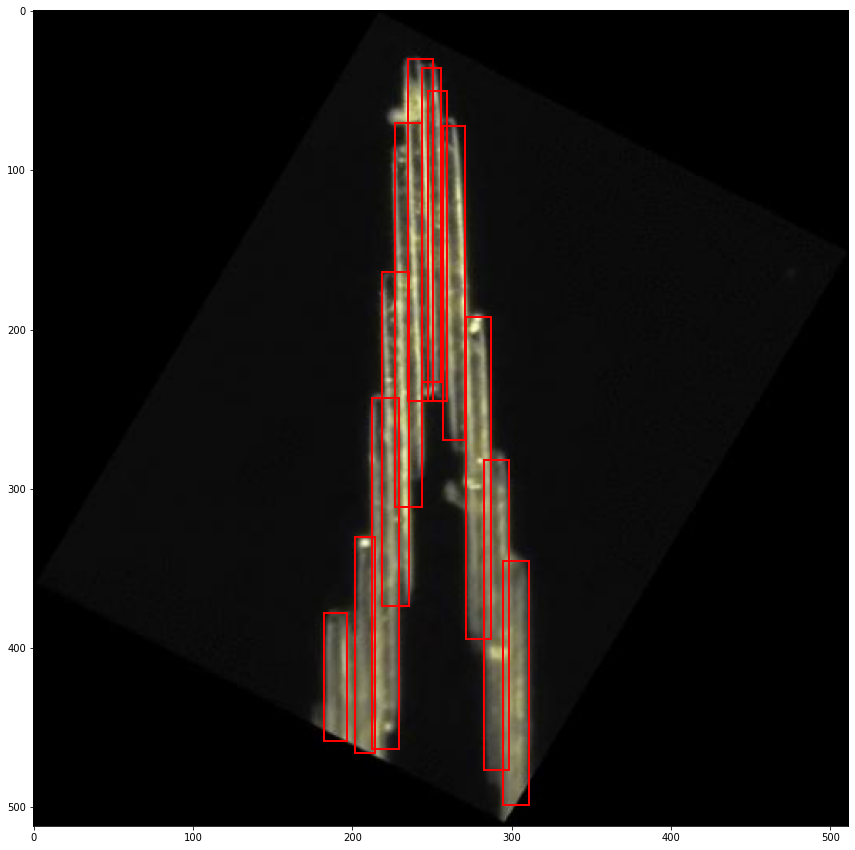

In [18]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Reading an image in default mode
image = img.mul(255).permute(1, 2, 0).byte().numpy()

# Window name in which image is displayed
window_name = 'Image'



# Blue color in BGR
color = (255, 0, 0)

# Line thickness of 2 px
thickness = 2
# for box in prediction[0]['boxes'][indc].cpu().numpy():
#   start_point = (box[0], box[1])
#   end_point = (box[2], box[3])
  # image = cv2.rectangle(image, start_point, end_point, color, thickness)
# Using cv2.rectangle() method
# Draw a rectangle with blue line borders of thickness of 2 px
#image = cv2.rectangle(image, start_point, end_point, color, thickness)

# Displaying the image
#cv2_imshow(image)
#plt.imshow(image)


fig, ax = plt.subplots(figsize=(15, 15))

# Display the image
ax.imshow(image)

for box in prediction[0]['boxes'][indc].cpu().numpy():
  ax.add_patch(patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none'))



plt.show()